In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb

import wandb
from wandb.lightgbm import wandb_callback

pd.set_option("display.max_columns", 181)
pd.set_option("display.min_rows", 200)

In [ ]:
#!pip install xgboost

In [ ]:
data_dictionary = pd.read_csv("DataDictionaryWiDS2021.csv")
unlabeled = pd.read_csv("UnlabeledWiDS2021.csv")
training = pd.read_csv("TrainingWiDS2021.csv")

In [ ]:
column_datatype_mapping = dict(zip(data_dictionary['Variable Name'], data_dictionary['Data Type']))

In [ ]:
del training['Unnamed: 0']
del unlabeled['Unnamed: 0']

In [64]:
unlabeled

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,82,admit,Med-Surg ICU,0.015278,0,NaN,2.8,110.0,104.01,0,0,1.9,44.0,1.49,NaN,4.0,6.0,0.0,5.0,97.0,38.0,39.9,0,54.0,NaN,NaN,NaN,NaN,31.0,130.0,36.40,NaN,0,5.4,NaN,NaN,104.0,40.0,104.0,40.0,66.0,38.0,NaN,NaN,123.0,54.0,123.0,54.0,35.0,15.0,100.0,96.0,NaN,NaN,149.0,76.0,149.000,76.0,38.700,35.6,NaN,NaN,59.0,59.0,59.0,59.0,46.0,44.0,NaN,NaN,80.0,80.0,80.0,80.0,19.0,19.0,97.0,96.0,NaN,NaN,116.0,116.0,116.0,116.0,36.4,36.4,2.8,2.8,1.9,1.9,44.0,40.0,9.8,9.3,1.49,1.44,104.0,97.0,26.0,23.0,14.5,14.2,42.8000,39.9,NaN,NaN,NaN,NaN,173.0,173.0,5.700,4.9,132.0,130.0,5.6,5.4,2.8,2.8,1.9,1.9,40.0,40.0,9.8,9.8,1.49,1.49,104.0,104.0,26.0,26.0,14.500,14.5,42.8,42.8,NaN,NaN,NaN,NaN,173.0,173.0,4.9,4.9,132.0,132.0,5.6,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,82,admit,Med-Surg ICU,0.000000,0,NaN,NaN,117.0,106.01,0,0,NaN,19.0,0.92,NaN,4.0,6.0,0.0,5.0,73.0,116.0,NaN,0,41.0,NaN,NaN,NaN,NaN,53.0,142.0,36.30,NaN,0,NaN,NaN,NaN,101.0,27.0,101.0,2

In [43]:
all_data = training.append(unlabeled).drop(['encounter_id', 
                                            'hospital_id', 
                                            'diabetes_mellitus'], axis=1)

all_data.shape

(140391, 177)

In [44]:
# get rid of features that have more than 40%
missing_cols = all_data.isnull().mean().sort_values(ascending=False)
drop_features = missing_cols[missing_cols>.8].index

all_data[drop_features].shape

(140391, 32)

In [45]:
drop_features

Index(['h1_bilirubin_max', 'h1_bilirubin_min', 'h1_albumin_min',
       'h1_albumin_max', 'h1_lactate_min', 'h1_lactate_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_min',
       'h1_arterial_ph_max', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_hco3_min',
       'h1_hco3_max', 'h1_wbc_max', 'h1_wbc_min', 'h1_calcium_min',
       'h1_calcium_max', 'h1_platelets_max', 'h1_platelets_min', 'h1_bun_min',
       'h1_bun_max', 'h1_creatinine_max', 'h1_creatinine_min',
       'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_mbp_invasive_min',
       'h1_mbp_invasive_max'],
      dtype='object')

In [46]:
all_data.drop(drop_features, axis=1, inplace=True)

In [47]:
cat_cols = []
cont_cols = []
for col in all_data.columns:
    if all_data.dtypes[col] == "object":
        cat_cols.append(col)
        all_data[col] = all_data[col].fillna("NA")
        all_data[col] = LabelEncoder().fit_transform(all_data[col])
        all_data[col]= all_data[col].astype('category')
    elif column_datatype_mapping[col] == "binary":
        all_data[col] = all_data[col].fillna(-1)
    elif column_datatype_mapping[col] == "numeric":
        all_data[col] = all_data[col].fillna(0)
        cont_cols.append(col)
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())
        cont_cols.append(col)

In [48]:
all_data.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,68.0,22.732803,0,2,1,180.3,4,1,92,0,2,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,0.0,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,0.0,0.0,0.0,0.00,36.0,134.0,39.3,0.0,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,0.0,0.0,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0,0,0,0,0,0,0
1,77.0,27.421875,0,2,0,160.0,4,1,90,0,5,0.927778,0,70.2,0.0,108.0,203.01,0,0,0.0,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,0.0,1,12.7,0.0,0.0,95.0,31.0,95.0,31.0,118.0,72.0,0.0,0.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,0.0,0.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,36.3,36.3,1.6,1.6,0.5,0.5,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,1.3,1.3,3.5,3.5,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,145.0,143.0,11.3,11.3,36.9,36.9,1.3,1.3,4.2,4.2,145.0,145.0,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,0,0,0,0,0,0,0
2,25.0,31.952749,0,2,0,172.7,3,0,93,0,5,0.000694,0,95.3,0.0,122.0,703.03,0,0,0.0,0.0,0.00,0.0,3.0,6.0,0.0,5.0,0.0,102.0,0.0,0,68.0,0.0,0.0,0.0,0.00,37.0,0.0,36.7,0.0,0,0.0,0.0,0.0,88.0,48.0,88.0,48.0,96.0,68.0,0.0,0.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,0.0,0.0,148.0,105.0,148.0,105.0,37.0,36.7,88.0,58.0,88.0,58.0,96.0,78.0,91.0,83.0,91.0,83.0,20.0,16.0,98.

In [49]:
df_train = all_data[:len(training)]
df_pred = all_data[len(training):].reset_index(drop=True)
Y = training['diabetes_mellitus']

In [50]:
df_train.columns

Index(['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type',
       ...
       'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=145)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(df_train, Y, test_size=0.20, random_state=42,shuffle=True )

In [20]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [ ]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 10, 
         'min_child_weight': 1, 
         'max_depth': 6, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': .6,
         'n_estimators':1000,
          'eval_metric':'auc',
          'objective': 'binary:logistic'}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

In [75]:
pd.DataFrame(pred).to_csv('submissions/xgb_pred.csv')

In [22]:
#bst.fit(df_train.values, Y.values)
#0.9692300714861747
metrics.roc_auc_score(Y.values, bst.predict(xgb.DMatrix(df_train.values)))

0.9699508705079491

In [54]:
pred_proba = bst.predict(xgb.DMatrix(df_pred.values))

#pred_proba = xgbm.predict_proba(df_pred.values)[:,1]]

In [55]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('submissions/SolutionWiDS2021_XGB_1000_epochs_best_params_features_dropped_80.csv')

## XGB fit on the entire dataset

In [52]:
xg_train = xgb.DMatrix(df_train.values, label=Y)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [ ]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 10, 
         'min_child_weight': 1, 
         'max_depth': 6, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': .6,
         'n_estimators':1000,
          'eval_metric':'auc',
          'objective': 'binary:logistic',
          'early_stopping_rounds':50}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

### CV with random hpopt

In [10]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1.5, 3],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [4, 5, 6],
        'num_leaves': [10, 20, 30],
        'learning_rate': [0.01, 0.1, 0.2, 0.4]
        }


In [11]:
xgb = XGBClassifier(n_estimators=200, objective='binary:logistic', verbose=1)

In [18]:
folds = 4
param_comb = 250

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=32, cv=skf.split(df_train.values, Y), verbose=3, 
                                   random_state=1001)


In [ ]:
# Here we go
import time
start=time.time()
random_search.fit(df_train.values, Y)
print(time.time()-start)

Fitting 4 folds for each of 250 candidates, totalling 1000 fits


In [20]:
random_search

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f7cb6aeb5d0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None, verbose=1,
                                          

In [22]:
print(random_search.best_params_)

{'subsample': 1.0, 'num_leaves': 10, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 0.6}


In [23]:
pred_proba_rs = random_search.predict_proba(df_pred.values)

In [ ]:
# (pred_proba, pred_proba_rs[:,1])

(array([4852., 1681.,  888.,  690.,  572.,  461.,  417.,  394.,  224.,
          55.]),
 array([7.5848104e-04, 9.6810319e-02, 1.9286215e-01, 2.8891400e-01,
        3.8496581e-01, 4.8101765e-01, 5.7706946e-01, 6.7312133e-01,
        7.6917315e-01, 8.6522502e-01, 9.6127683e-01], dtype=float32),
 <BarContainer object of 10 artists>)

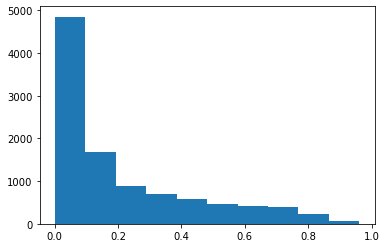

In [24]:
import matplotlib.pyplot as plt
plt.hist(pred_proba_rs[:,1])

In [84]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba_rs[:,1]]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('SolutionWiDS2021_XGB_200_epochs_CV_RandomSearch_200runs.csv')